In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import packages and formatting statements

import numpy as np
from matplotlib import pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os

plt.rc('text',usetex=False)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

In [3]:
# Compile galaxy and OSC objects
# full catalog header: Name,Type,Host,RA hms,Dec dms,RA dds,Dec dds,DiscDate

DataFile = '../Data/0.MUSEdata.csv'
Data = Table.read(DataFile, format='csv') 
galaxies, dists =  Data["Galaxy"], Data["Distance"]
MUSEres, MUSENatMaps, MUSE150pcMaps, MUSEHII, MUSEIRAC = Data["MUSENatRes"], Data["MUSEmapNat"], Data["MUSEmap150pc"], Data["MUSE_HII_reg"], Data["IRAC_files"]
SNe, types = np.loadtxt('../Data/1.FullCatalog.csv', dtype = str, delimiter = ",",unpack=True, usecols = (0,1))
ras, decs = np.loadtxt('../Data/1.FullCatalog.csv',delimiter=',', unpack = True, usecols=(5,6))



In [33]:
#Checks if Supernovae are in an image and reports back their x & y coords if in map

def check_in_image(SNras, SNdecs, SNnames, SNtypes, image):
    intensity = []
    hdulist  = pyfits.open(image)
    
    map = hdulist["HA6562_FLUX"].data
    #emap = hdulist["HA6562_FLUX_ERR"].data     
    wcs = WCS(hdulist["HA6562_FLUX"].header, naxis=2)
    naxis = wcs._naxis #size of image
    naxis1 = hdulist["HA6562_FLUX"].header['NAXIS1']
    naxis2 = hdulist["HA6562_FLUX"].header['NAXIS2']

        
    coords_arr = np.column_stack((SNras, SNdecs)) # ras and decs now [ra,dec]
    pix_x, pix_y = wcs.wcs_world2pix(SNras,SNdecs,0)

    #use world coordinates of all SNe to see if any fall in image (our version of footprint_contains)

    is_in_x = (pix_x >= 0) & (pix_x <= naxis[0]-1) #because of 0-indexing
    is_in_y = (pix_y >= 0) & (pix_y <= naxis[1]-1)
             
    #get the name, ra, and dec of the SNe that fall in image
    #boolean array indexing (gives back array of Trues and Falses)
    #we are pulling out the SNe that are True and assigning them to own arrays
    name_in_image = np.array(SNnames)[is_in_x & is_in_y]
    type_in_image = np.array(SNtypes)[is_in_x & is_in_y]
    ra_in_image = np.array(SNras)[is_in_x & is_in_y]
    dec_in_image = np.array(SNdecs)[is_in_x & is_in_y]

    x_coord = np.array(pix_x)[is_in_x & is_in_y]
    y_coord = np.array(pix_y)[is_in_x & is_in_y]
    for i in range(len(x_coord)):
        if x_coord != "[]":
            intensity.append(map[int(round(float(y_coord[i]))),int(round(float(x_coord[i])))])
    print(intensity)
    
    return(name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord, map, naxis1, naxis2, intensity)
    #print(name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord)


In [36]:
# Build MUSE Catalogue That has all supernovae within PHANGS-MUSE footprint

with open('../Data/2.MUSESNeSample.txt', 'w') as text_file:
    print('Galaxy,Distance,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSEHII,IRACfiles,Intensity', file = text_file)

for i in range(len(galaxies)):
    if (MUSE150pcMaps[i] != "" and os.path.isfile(MUSE150pcMaps[i])):
    
        found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, naxis1, naxis2, intensity = check_in_image(ras, decs, SNe, types, MUSE150pcMaps[i])

        with open('../Data/2.MUSESNeSample.txt', 'a') as text_file:
            for j in range(len(found_name)):
                print(galaxies[i], ",", dists[i],",", found_name[j],",", found_type[j],",", found_ra[j], ",",found_dec[j],
                      ",", MUSEres[i],",", MUSENatMaps[i],",", MUSE150pcMaps[i], ",",MUSEHII[i],",",MUSEIRAC[i],",",intensity[j], file = text_file)


[]
[]
[2851.421676185079]
[-0.49878611]
[291.17327796533147]
[-19.39518889]
[1864.5543905682587, 4412.194586792122, 1147.937890443259, 73.60162009780304]
[-36.11770833 -36.14859167 -36.14211111 -36.12676944]
[]
[]
[171.70688017559416]
[-47.20998722]
[]
[]
[3053.614935125523, 320.1414131766342, 117.0347673829065]
[-54.93807778 -54.94402778 -54.94808056]
[3510.4729583640315, 16811.57551530723]
[-59.24512778 -59.24538333]
[]
[]
[]
[]
[2770.3709709890186, 6341.511837790957, 344.2339568155673, 9610.51771941654, 1731.367827556123]
[12.99774    13.00530778 12.97210741 12.97956944 12.98244949]
[3424.8032209831545, 1597.1279821389421, 4098.8667227786045, 11490.532045150616]
[14.41404861 14.44432639 14.41226611 14.41206944]
[810.8031791539183, 3033.946401082417, 253.67922934189994, 13072.412027543538, 2688.935931726846, 651.9700753247237, 778.7494382940001]
[4.49335417 4.47037963 4.47377083 4.46267685 4.48797083 4.47177778
 4.48169278]
[222.3275830717548, 755.2585628327931, 1310.7929124372315, n

In [37]:
# Turn files into data structure and clean

MUSEdataFile = '../Data/2.MUSESNeSample.txt'
database = Table.read(MUSEdataFile, format='ascii') 
database[0:2]

Galaxy,Distance,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSEHII,IRACfiles,Intensity
str7,float64,str11,str12,float64,float64,float64,str71,str70,str50,str40,float64
NGC1087,15.85,SN1995V,II,41.61152777777777,-0.4987861111111111,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1087-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,2851.421676185079
NGC1300,18.99,SN2022acko,II,49.91245833333333,-19.39518888888889,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1300-0.89asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1300-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2.fits,../Data/IRAC/ngc1300_irac1_atGauss4.fits,291.17327796533147


In [38]:

SN_name = [x[2:-2] for x in database["Supernova"]]

# Here we are going to filter out our undesired OSC entries:
    # One is a double counted SN named "PTSS-19clju", any LRNs or LBVs, and any candidates

flags = []
flag1 = database['Supernova'] == "PTSS-19clju" 
flag3 = database['Supernova'] == "Gaia21fml" 
flag5 = database['Supernova'] == "Gaia21cum"
flag6 = database["Supernova"] =="SN2013ej" 
flag7 = database["Supernova"] =="SN1979C"

flag2 = []

for i in range(len(SN_name)):
    if ("LRN" in database['Type'][i] or "LBV" in database['Type'][i] or "Candidate" in database['Type'][i]):
        flag2.append(True)
    else:
        flag2.append(False)

for i in range(len(flag1)):
    if flag1[i] == True or flag2[i] == True or flag3[i] == True or flag5[i] == True or flag6[i] == True or flag7[i] == True:
        flags.append(False)
    else:
        flags.append(True)
        
flagsArr = np.array(flags)

c = Column(data=flags, name='InSample')
database.add_column(c)
ascii.write(database, '../Data/2.MUSEMasterCat.csv', format='csv', fast_writer=False, overwrite = True) 

cleanData = database[flagsArr==True]

cleanData

ascii.write(cleanData, '../Data/2.MUSESampleCat.csv', format='csv', fast_writer=False, overwrite = True)  

In [39]:
cleanData[0:2]

Galaxy,Distance,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSEHII,IRACfiles,Intensity,InSample
str7,float64,str11,str12,float64,float64,float64,str71,str70,str50,str40,float64,bool
NGC1087,15.85,SN1995V,II,41.61152777777777,-0.4987861111111111,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1087-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,2851.421676185079,True
NGC1300,18.99,SN2022acko,II,49.91245833333333,-19.39518888888889,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1300-0.89asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1300-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2.fits,../Data/IRAC/ngc1300_irac1_atGauss4.fits,291.17327796533147,True


In [45]:
# Plot MUSE Galaxy Files with SNe using native resolutions 
inMuse = []

for i in range(len(cleanData["Galaxy"])):
    
    if (cleanData["MUSENatMap"][i] != "" and os.path.isfile(cleanData["MUSENatMap"][i])):     
    
        found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, naxis1, naxis2,intensity = check_in_image(cleanData['Ra'],
                                            cleanData['Dec'], cleanData['Supernova'], cleanData['Type'], cleanData["MUSENatMap"][i])
    
        plt.figure(figsize=(7, 7))
        logmap = np.log10(map)
        plt.imshow(logmap, origin='lower', interpolation='nearest', zorder=1)

        for k in range(len(found_name)):
            inMuse.append(found_name[k])
            string = found_name[k]

            if (len(found_type[k])>1):
                if found_type[k][1] == "I":
                    #colorCode = 'chartreuse'
                    colorCode = 'black'
                    mkr = '*'
                elif found_type[k][1] == "b" or found_type[k][1] == "c":
                    #colorCode = 'salmon'
                    colorCode = 'darkblue'
                    mkr = '^'
                elif found_type[k][1] == "a":
                    #colorCode = 'deeppink'
                    colorCode = 'indigo'
                    mkr = 'o'
                else:
                    colorCode = 'magenta'
                    mkr = '>'
            else:
                #colorCode = 'cyan'
                colorCode = 'maroon'
                mkr='s'

            plt.plot(x_coord[k], y_coord[k], marker=mkr, ms=10, color=colorCode, zorder=10)
            plt.text(x_coord[k]-20, y_coord[k]+8, string, fontsize=12, color=colorCode)

        plt.axis('off')
        plt.title(cleanData["Galaxy"][i], fontsize=24, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../Figures/GalaxyImages/' + cleanData["Galaxy"][i] + '.png')
        plt.close()

[2663.371834437333]
[-0.49878611]
[215.43198181769688]
[-19.39518889]
[1737.6042541521983, 5743.357614386635, 929.5770449217084, 69.97068734325512]
[-36.11770833 -36.14859167 -36.14211111 -36.12676944]
[1737.6042541521983, 5743.357614386635, 929.5770449217084, 69.97068734325512]
[-36.11770833 -36.14859167 -36.14211111 -36.12676944]
[1737.6042541521983, 5743.357614386635, 929.5770449217084, 69.97068734325512]
[-36.11770833 -36.14859167 -36.14211111 -36.12676944]
[1737.6042541521983, 5743.357614386635, 929.5770449217084, 69.97068734325512]
[-36.11770833 -36.14859167 -36.14211111 -36.12676944]
[162.95929157157056]
[-47.20998722]
[2552.702982824482, 247.78910338751842, 99.3203429556626]
[-54.93807778 -54.94402778 -54.94808056]
[2552.702982824482, 247.78910338751842, 99.3203429556626]
[-54.93807778 -54.94402778 -54.94808056]
[2552.702982824482, 247.78910338751842, 99.3203429556626]
[-54.93807778 -54.94402778 -54.94808056]
[3288.5962211884453, 13053.931693480788]
[-59.24512778 -59.24538333]


In [46]:
#Group data by galaxy
gal_groups = cleanData.group_by('Galaxy')
gals = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)

# print(gals)
# print(indices)

galaxies, images, name, types, ras, decs = [],[],[],[],[],[]
# errfiles, dists = [],[]
for i in range(len(indices)-2):
    
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]
    images.append(gal_groups["MUSENatMap"][indices[i]])
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["Ra"][indices[i]])
    SNdecs.append(gal_groups["Dec"][indices[i]])
    j = 1
    
    while(indices[i] + j < indices[i+1]):
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["Ra"][indices[i]+j])
        SNdecs.append(gal_groups["Dec"][indices[i]+j])
        j += 1
    
    if len(SNnames) != 0:
        name.append(SNnames)
        types.append(SNtypes)
        ras.append(SNras)
        decs.append(SNdecs)
        galaxies.append(gals[i][0])

print(decs)
print(galaxies)

[[-0.4987861111111111], [-19.39518888888889], [-36.11770833333333, -36.14859166666667, -36.142111111111106, -36.12676944444445], [-47.209987222222225], [-54.93807777777778, -54.94402777777778, -54.94808055555555], [-59.24512777777778, -59.245383333333336], [12.997739999999999, 13.005307777777778, 12.972107407407407, 12.979569444444444, 12.98244948888889], [14.41404861111111, 14.44432638888889, 14.412266111111112, 14.412069444444445], [4.493354166666666, 4.47037962962963, 4.473770833333334, 4.462676851851852, 4.487970833333334, 4.471777777777778, 4.481692777777778], [15.82375, 15.816989814814816, 15.809006481481482, 15.826070370370369, 15.8236125]]
['NGC1087', 'NGC1300', 'NGC1365', 'NGC1433', 'NGC1566', 'NGC1672', 'NGC3627', 'NGC4254', 'NGC4303', 'NGC4321']


In [47]:
# set up plots.
import matplotlib.pyplot as plt
SNgals, plots, wcss, legendLabels = [],[],[],[]
# beamsizes, plotAspect, ppb, corner, scalebars = [],[],[],[],[],[],[],[],[]


for i in range(len(galaxies)):
        
    if os.path.isfile(images[i]):
        SNgals.append(galaxies[i])
        img = images[i]
        hdu = pyfits.open(img)
        img_map = hdu["HA6562_FLUX"].data
        plots.append(img_map)
        w = WCS(hdu["HA6562_FLUX"].header, naxis=2)
        wcss.append(w)
        
        legendlabel = []
        if len(name[i]) > 1:
            for k in range(len(name[i])):
                if types[i][k] == 'Unclassified':
                    typelabel = name[i][k] + ' '  + types[i][k]
                else:
                    typelabel = name[i][k] + ' Type '  + types[i][k]
                legendlabel.append(typelabel)
        else:
            if types[i][0] == 'Unclassified':
                legendlabel.append(name[i][0] + ' '  + types[i][0]) 
            else:        
                legendlabel.append(name[i][0] + ' Type '  + types[i][0])
        legendLabels.append(legendlabel)
        
# print(legendLabels)
# print(SNgals)
# print(len(plots))
# for i in range(len(SNgals)):
#     for j in range(len(ras[i])):
#         print(SNgals[i], ras[i][j])

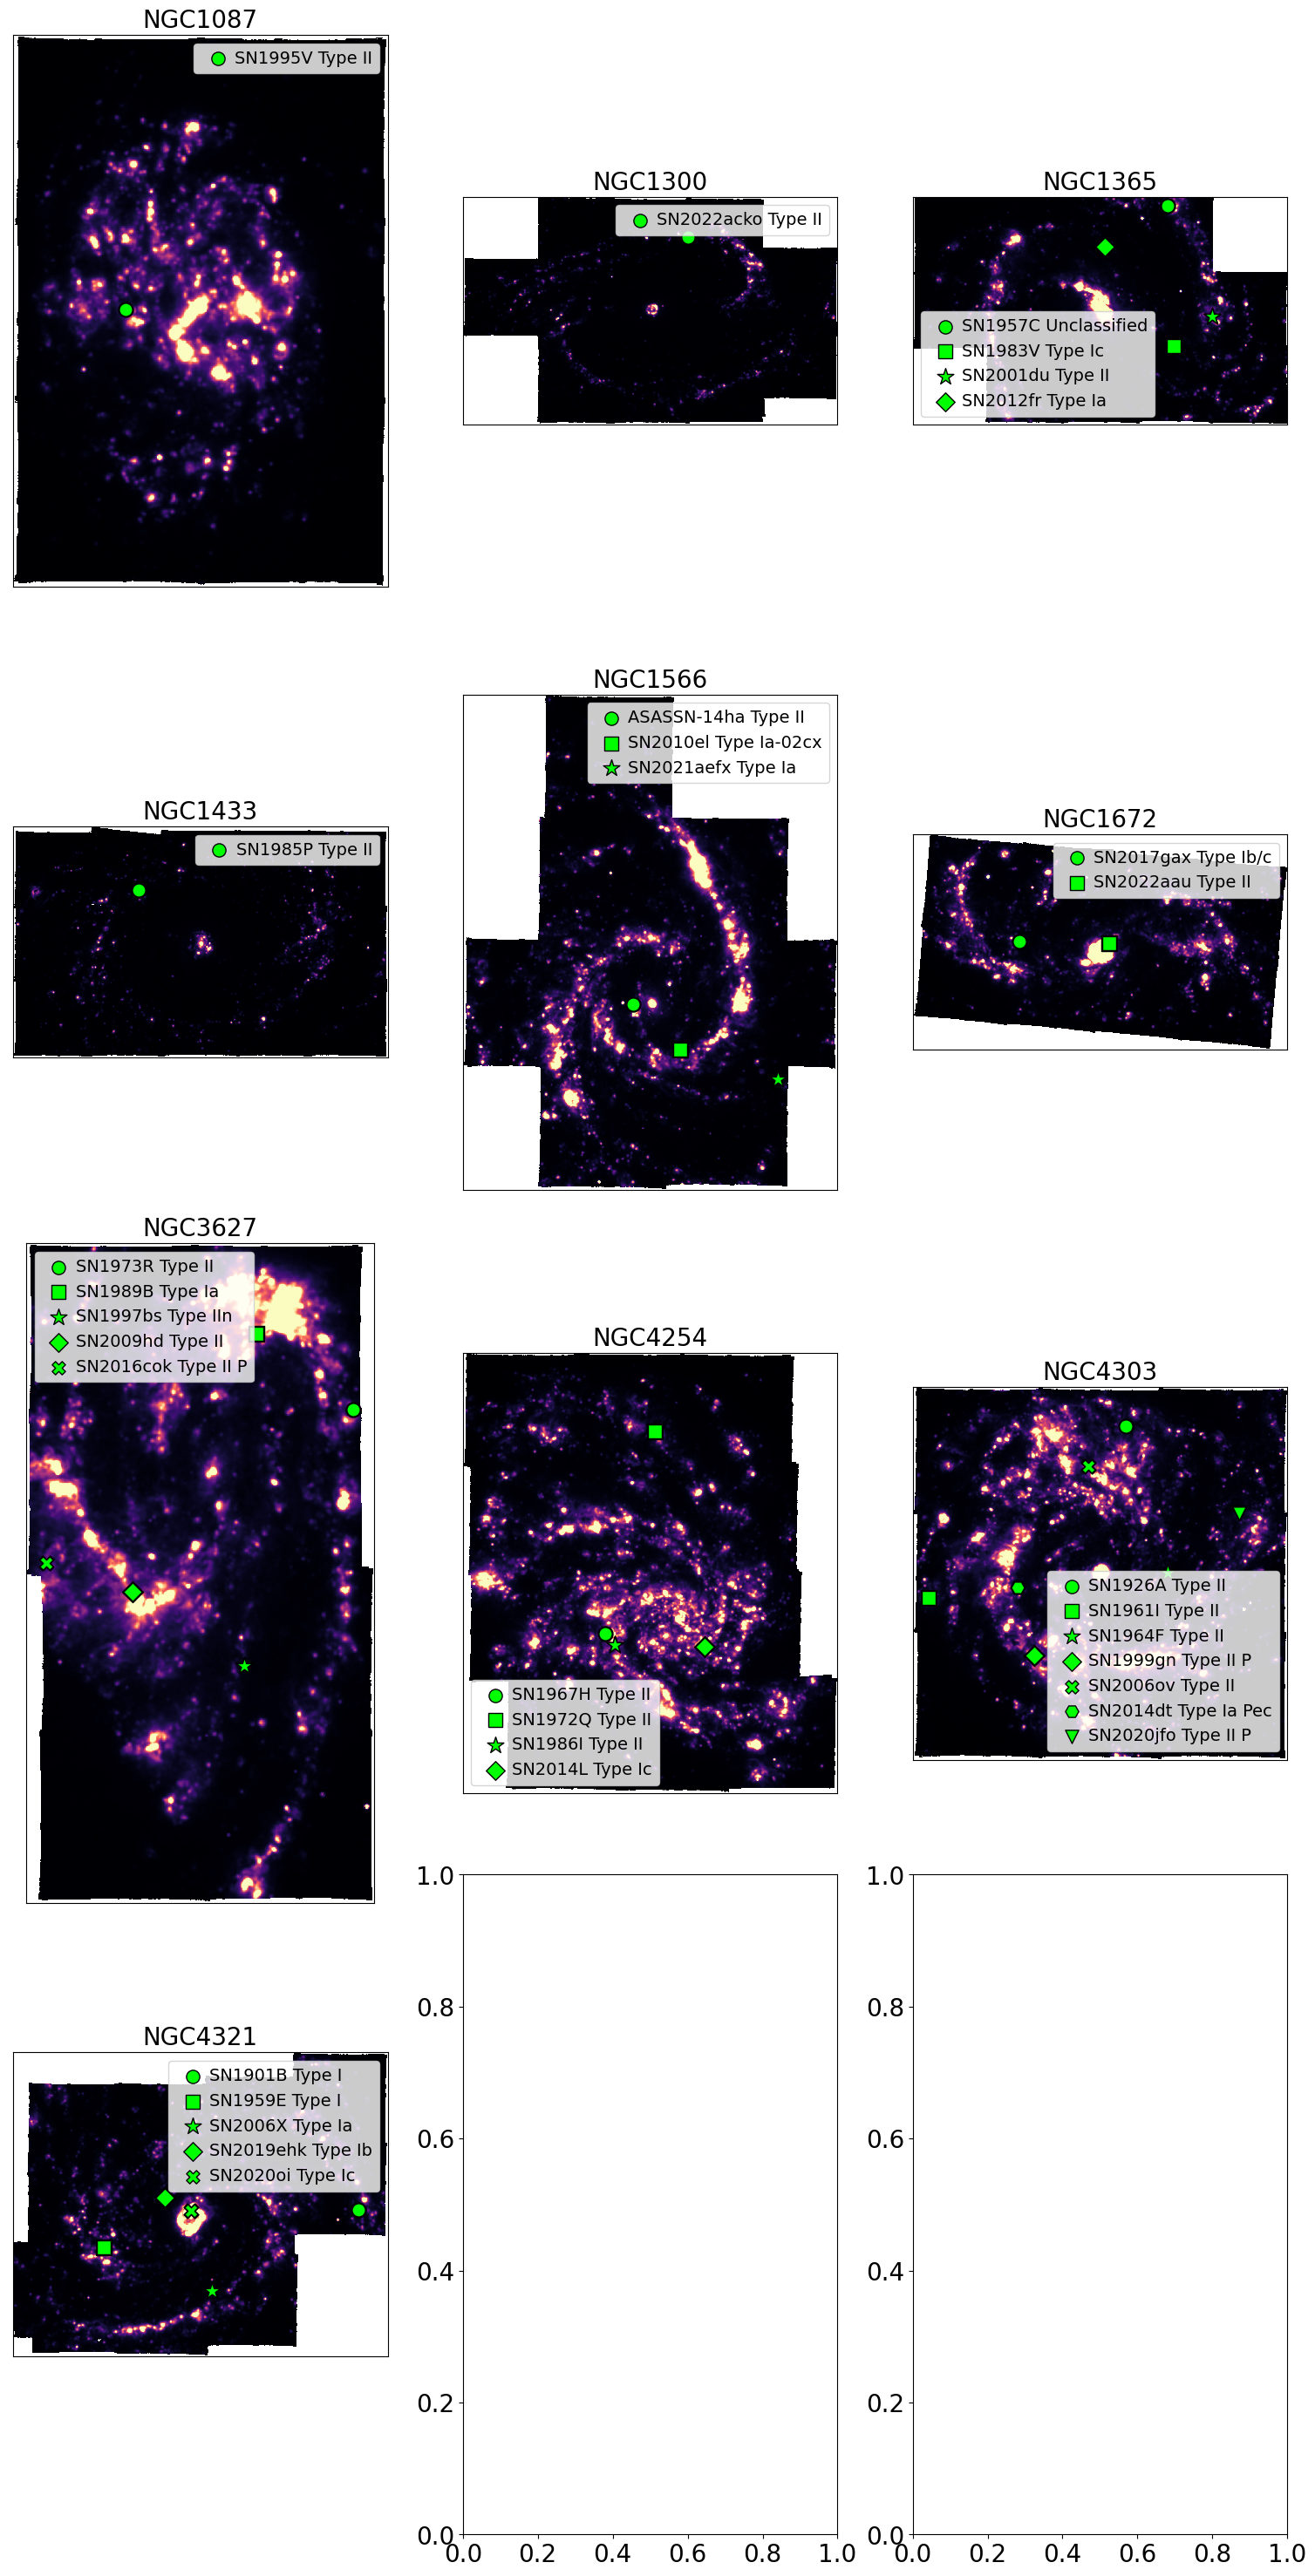

In [48]:
from matplotlib.patches import Circle


markerShapes = ["o", "s", "*", "D", "X", "H", "v"]
markerSizes  = [120,120,200,120,120,120,120]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("white")

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(15, 30))
for plot in plots:

    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    logplot = np.log10(plot)
    axs[i][j].imshow(plot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest",
                    vmin=-0.1, vmax=10000)
    axs[i][j].set_title(SNgals[m].upper(), fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    for n in range(len(decs[m])):
        axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
        axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                          edgecolor="black", label = legendLabels[m][n])
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m +=1
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/MUSEGalaxies.pdf", dpi=300)
   

print()

In [49]:
cleanData

Galaxy,Distance,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSEHII,IRACfiles,Intensity,InSample
str7,float64,str11,str12,float64,float64,float64,str71,str70,str50,str40,float64,bool
NGC1087,15.85,SN1995V,II,41.61152777777777,-0.4987861111111111,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1087-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,2851.421676185079,True
NGC1300,18.99,SN2022acko,II,49.91245833333333,-19.39518888888889,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1300-0.89asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1300-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2.fits,../Data/IRAC/ngc1300_irac1_atGauss4.fits,291.17327796533147,True
NGC1365,19.57,SN1957C,Unclassified,53.38349999999999,-36.11770833333333,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,1864.5543905682587,True
NGC1365,19.57,SN1983V,Ic,53.381876388888884,-36.14859166666667,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,4412.194586792122,True
NGC1365,19.57,SN2001du,II,53.3713125,-36.142111111111106,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,1147.937890443259,True
NGC1365,19.57,SN2012fr,Ia,53.40057916666666,-36.12676944444445,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,73.60162009780304,True
...,...,...,...,...,...,...,...,...,...,...,...,...
NGC4303,16.99,SN2014dt,Ia Pec,185.48991666666666,4.471777777777778,0.78,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC4303-0.78asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC4303-150pc_MAPS.fits,../Data/HII_reg_masks/NGC4303_nebulae_mask_V2.fits,../Data/IRAC/ngc4303_irac1_atGauss4.fits,651.9700753247237,True
NGC4303,16.99,SN2020jfo,II P,185.46016458333332,4.481692777777778,0.78,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC4303-0.78asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC4303-150pc_MAPS.fits,../Data/HII_reg_masks/NGC4303_nebulae_mask_V2.fits,../Data/IRAC/ngc4303_irac1_atGauss4.fits,778.7494382940001,True


In [51]:
for i in range(len(cleanData)):
    print(cleanData["Intensity"][i])

2851.421676185079
291.17327796533147
1864.5543905682587
4412.194586792122
1147.937890443259
73.60162009780304
171.70688017559416
3053.614935125523
320.1414131766342
117.0347673829065
3510.4729583640315
16811.57551530723
2770.3709709890186
6341.511837790957
344.2339568155673
9610.51771941654
1731.367827556123
3424.8032209831545
1597.1279821389421
4098.8667227786045
11490.532045150616
810.8031791539183
3033.946401082417
253.67922934189994
13072.412027543538
2688.935931726846
651.9700753247237
778.7494382940001
755.2585628327931
1310.7929124372315
203.43808384956603
237.82316161258927
19032.486243820913
